In [1]:
import os 
import numpy as np 
import pandas as pd
import tensorflow as tf 

# Data
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Sequential, load_model
from keras.layers import Dense, GlobalAvgPool2D, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pretrained model 
from tensorflow.keras.applications import InceptionV3

In [2]:
rootpath = '/kaggle/input/bic123'

# Get Class Names
class_names = os.listdir(rootpath)[:2]
class_names

['0', '1']

In [3]:
class_dis = [len(os.listdir(rootpath + "/" + name)) for name in class_names]

# Plot
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [4]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    validation_split=0.2
)

In [5]:
train_ds = gen.flow_from_directory(
    rootpath,
    target_size=(256,256),
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='binary'
)

Found 7640 images belonging to 2 classes.


In [6]:
valid_ds = gen.flow_from_directory(
    rootpath,
    target_size=(256,256),
    subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode='binary'
)

Found 1909 images belonging to 2 classes.


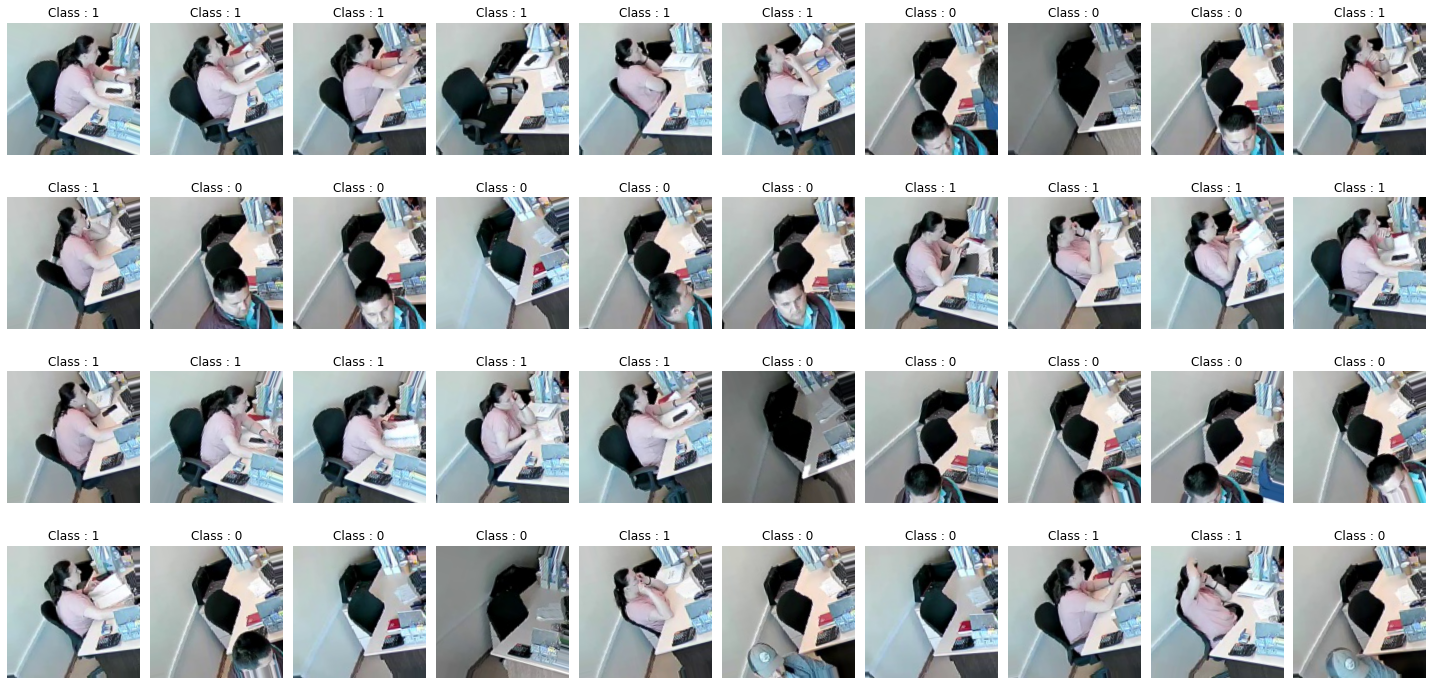

In [7]:
i=1
plt.figure(figsize=(20,10))
for images, labels in train_ds:
    
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    
    plt.subplot(4,10,i)
    plt.imshow(image)
    plt.title(f"Class : {class_names[label]}")
    plt.axis('off')
    
    i+=1
    if i>=41:
        break
plt.tight_layout()
plt.show()

In [8]:
base_model = InceptionV3(include_top=False, input_shape=(256,256,3))

# Freeze Weights
base_model.trainable = False

# Model Architecture
model = Sequential([
    base_model,
    GlobalAvgPool2D(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
], name="Inception-TL")

# Compile Model 
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks 
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint("Inception-TL.h5", save_best_only=True)]

# Model Training
model.fit(train_ds, validation_data=valid_ds, epochs=5, callbacks=cbs)

2022-12-11 21:52:09.313924: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 1s 0us/step


2022-12-11 21:52:14.003981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
239/239 [==============================] - 660s 3s/step - loss: 0.0463 - accuracy: 0.9843 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 2/5
239/239 [==============================] - 644s 3s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 3/5
239/239 [==============================] - 644s 3s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 4/5
239/239 [==============================] - 642s 3s/step - loss: 4.5176e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9995
Epoch 5/5
239/239 [==============================] - 643s 3s/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 2.2719e-04 - val_accuracy: 1.0000


In [9]:
model.evaluate(train_ds)

239/239 [==============================] - 514s 2s/step - loss: 5.2350e-05 - accuracy: 1.0000


[5.2349671022966504e-05, 1.0]

In [10]:
model.evaluate(valid_ds)

60/60 [==============================] - 129s 2s/step - loss: 4.4399e-05 - accuracy: 1.0000


[4.439863914740272e-05, 1.0]

In [11]:
model = load_model('/kaggle/working/Inception-TL.h5')

In [12]:
model.summary()

Model: "Inception-TL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 22,327,585
Trainable params: 524,801
Non-trainable params: 21,802,784
_________________________________________________________________


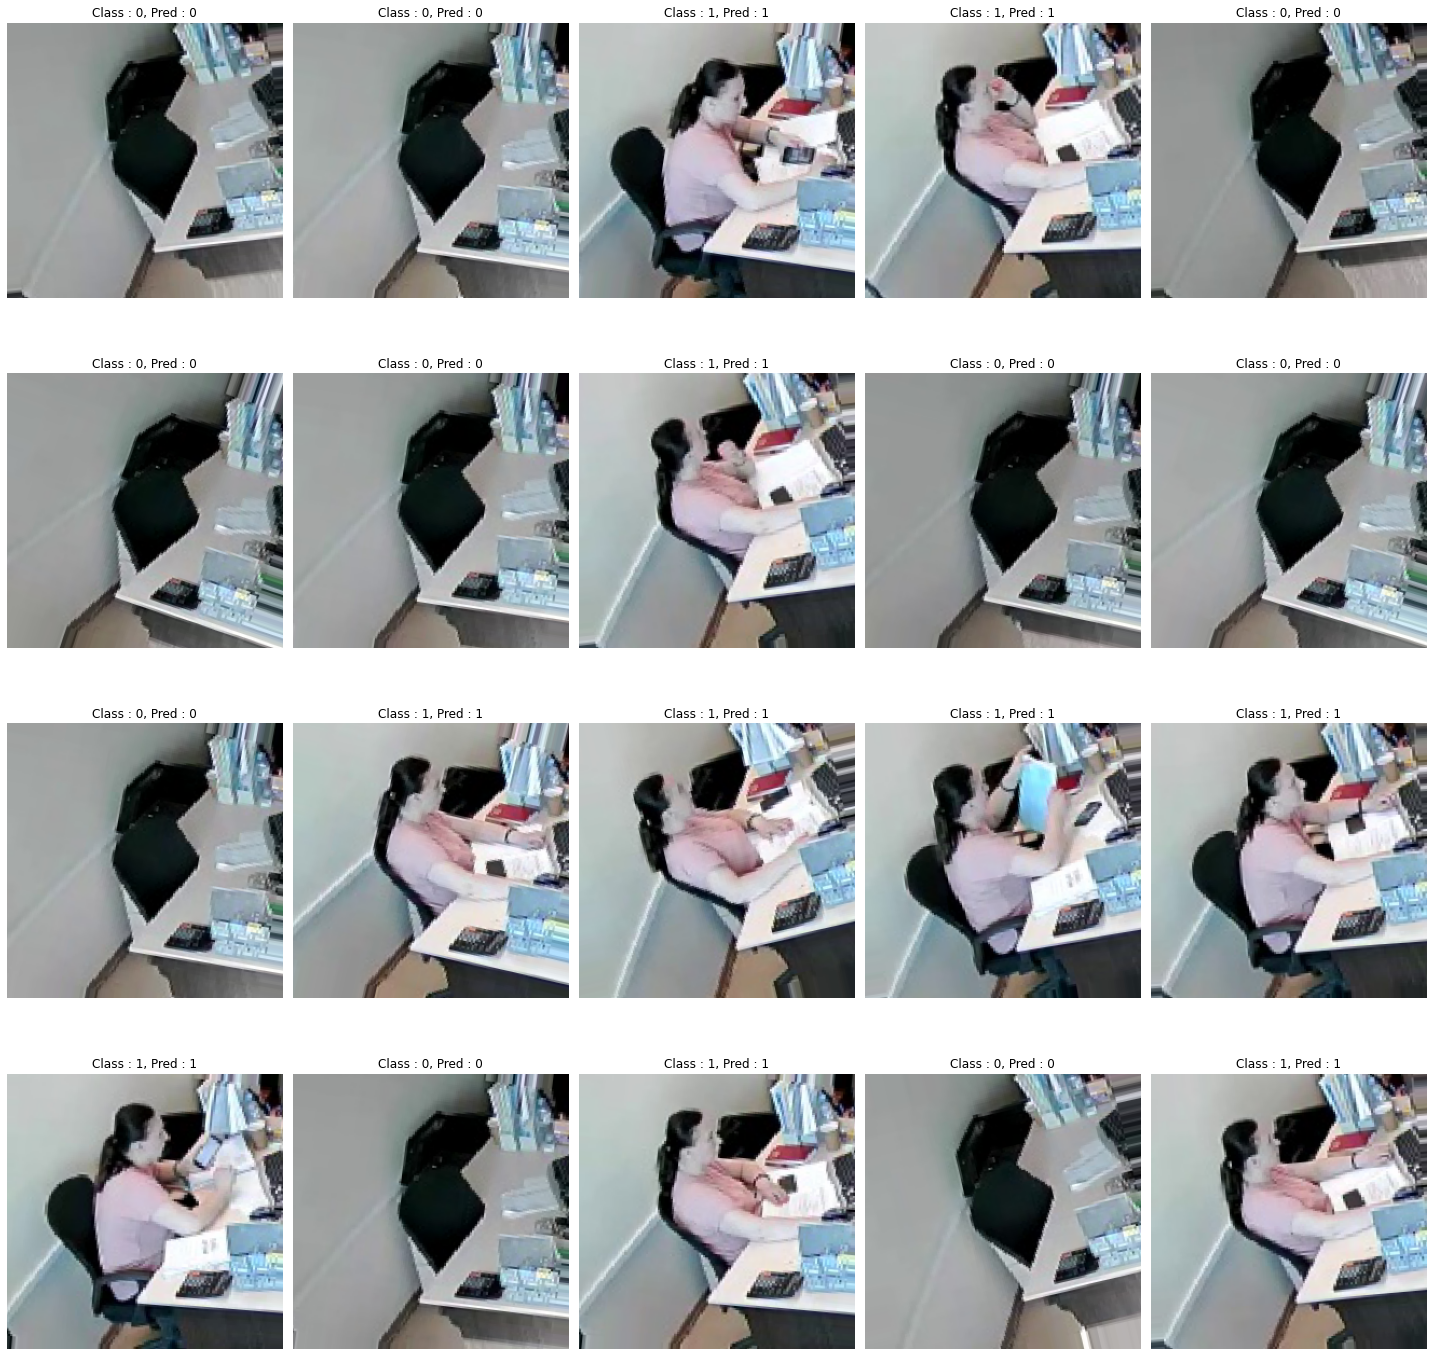

In [13]:
i=1
plt.figure(figsize=(20,20))
for images, labels in valid_ds:
    
    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])
    pred_label = int(np.round(model.predict(image.reshape(-1,256,256,3))))

    plt.subplot(4,5,i)
    plt.imshow(image)
    plt.title(f"Class : {class_names[label]}, Pred : {class_names[pred_label]}")
    plt.axis('off')
    
    i+=1
    if i>=21:
        break
plt.tight_layout()
plt.show()